# Cohort Analyses

## References

|Link|Notes|
|---|---|
|https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html|Basic spread models|
|https://www.insidermonkey.com/blog/donald-trump-has-3-3-percent-chance-of-dying-from-coronavirus-817781/|Basic risk mdoel|

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from ipypb import track
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from celluloid import Camera
import os
import scipy.stats as stats
import time
from ipypb import track

In [2]:
pd.options.display.max_columns = 999

## Data

Data Sources (keep it simple and focus on building the models)
- https://covidtracking.com/api/
- New York Times

In [3]:
nytCountyData = "C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data\\us-counties.csv"
folderOfJHUData = "C:\\Users\\garfink2\\Documents\\data\\covid\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"
excel_CountyPopulations = "C:\\Users\\garfink2\\Documents\\data\\basemap\\co-est2019-alldata.xlsx"

In [4]:
gdf_USCounties = gpd.read_file(shp_USCounties)
gdf_USStates = gpd.read_file(shp_USStates)

In [5]:
df_countyPouplations = pd.read_excel(excel_CountyPopulations)

## Add in population data to counties

In [6]:
fips = []
for i,row in df_countyPouplations.iterrows():
    fip = int(f"{row['STATE']}{str(row['COUNTY']).zfill(3)}")
    fips.append(fip)
df_countyPouplations["fips"] = fips

In [7]:
df_countyPouplations["fips"]

0        1000
1        1001
2        1003
3        1005
4        1007
        ...  
3188    56037
3189    56039
3190    56041
3191    56043
3192    56045
Name: fips, Length: 3193, dtype: int64

In [8]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry"]]

In [9]:
gdf_USCounties["GEOID"] = gdf_USCounties["GEOID"].astype("int")

In [10]:
len(fips)

3193

In [11]:
len(list(gdf_USCounties["GEOID"]))

3233

In [12]:
gdf_USCounties.sort_values("GEOID").head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
1328,01,001,1001,Autauga,Autauga County,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
1246,01,003,1003,Baldwin,Baldwin County,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
1827,01,005,1005,Barbour,Barbour County,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3014,01,007,1007,Bibb,Bibb County,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
855,01,009,1009,Blount,Blount County,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


In [13]:
gdf_USCounties = pd.merge(left=gdf_USCounties,right=df_countyPouplations,left_on="GEOID",right_on="fips")

In [14]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry","POPESTIMATE2019"]]

In [15]:
len(df_countyPouplations)

3193

In [16]:
len(gdf_USCounties)

3142

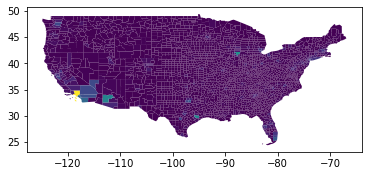

In [17]:
gdf_USCounties.cx[-125:-50, 20:70].plot("POPESTIMATE2019")

## Load the NYT Data

KLUDGE- create custom fips for New York City and Kansas City

In [18]:
df_nytCountyData = pd.read_csv(nytCountyData)

In [19]:
nycGeometry = gdf_USCounties[gdf_USCounties["GEOID"] == 36047].geometry.iloc[0]

In [20]:
kcGeometry = gdf_USCounties[gdf_USCounties["GEOID"] == 29095].geometry.iloc[0]

In [21]:
df_nytCountyData.loc[(df_nytCountyData.county=="New York City"),"fips"]=36047

In [22]:
df_nytCountyData.loc[(df_nytCountyData.county=="Kansas City"),"fips"]=29095

In [23]:
df_nytCountyData = df_nytCountyData.dropna(subset=["fips"])

In [24]:
df_nytCountyData["fips"] = df_nytCountyData["fips"].astype("int")

In [25]:
df_nytCountyData.sort_values("deaths",ascending=False)

,date,county,state,fips,cases,deaths
37185,2020-04-06,New York City,New York,36047,68776,2738
34709,2020-04-05,New York City,New York,36047,67552,2472
32273,2020-04-04,New York City,New York,36047,63307,2254
29882,2020-04-03,New York City,New York,36047,57160,1867
27559,2020-04-02,New York City,New York,36047,51810,1562
...,...,...,...,...,...,...
13178,2020-03-26,Humphreys,Mississippi,28053,1,0
13176,2020-03-26,Hinds,Mississippi,28049,43,0
13175,2020-03-26,Harrison,Mississippi,28047,31,0
13173,2020-03-26,Grenada,Mississippi,28043,2,0


In [26]:
gdf_countyTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_nytCountyData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

In [27]:
gdf_countyTimeSeries['date'] = pd.to_datetime(gdf_countyTimeSeries['date'], errors='coerce')

In [28]:
# overwrite the FIPS again now that its merged
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="New York City"),"fips"]=360470
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="Kansas City"),"fips"]=290950

In [29]:
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="New York City"),"geometry"]=nycGeometry
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="Kansas City"),"geometry"]=kcGeometry

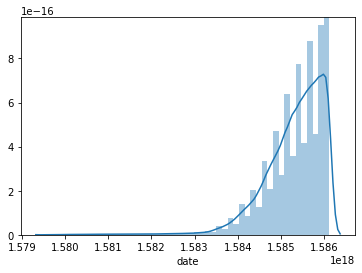

In [30]:
sns.distplot(gdf_countyTimeSeries["date"])

In [31]:
gdf_countyTimeSeriesDiff = gdf_countyTimeSeries.copy(deep=True)

In [32]:
gdf_countyTimeSeriesDiff["new cases"] = gdf_countyTimeSeriesDiff.groupby("fips")[["cases"]].diff().fillna(0)
gdf_countyTimeSeriesDiff["new deaths"] = gdf_countyTimeSeriesDiff.groupby("fips")[["deaths"]].diff().fillna(0)

In [33]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["date"] == dt.datetime(month=4,day=6,year=2020)].sort_values("new cases",ascending=False)

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019,new cases,new deaths
3894,2020-04-06,Suffolk,New York,36103,14473,237,36,103,36103,Suffolk,Suffolk County,"POLYGON ((-72.86371 41.11338, -72.86351 41.113...",1476601,1540.0,62.0
1361,2020-04-06,New York City,New York,360470,68776,2738,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,1224.0,266.0
2047,2020-04-06,Nassau,New York,36059,15616,535,36,059,36059,Nassau,Nassau County,"POLYGON ((-73.69445 40.90305, -73.62815 40.941...",1356924,1218.0,139.0
5131,2020-04-06,Wayne,Michigan,26163,8270,346,26,163,26163,Wayne,Wayne County,"POLYGON ((-83.28780 42.44268, -83.28764 42.442...",1749343,752.0,53.0
150,2020-04-06,Cook,Illinois,17031,8728,209,17,031,17031,Cook,Cook County,"POLYGON ((-88.23798 42.06693, -88.23797 42.066...",5150233,685.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,2020-04-06,Madera,California,6039,28,2,06,039,6039,Madera,Madera County,"POLYGON ((-120.10639 37.16715, -120.10577 37.1...",157327,-2.0,0.0
30305,2020-04-06,Ohio,West Virginia,54069,15,0,54,069,54069,Ohio,Ohio County,"POLYGON ((-80.62760 40.02517, -80.62770 40.025...",41411,-3.0,0.0
22823,2020-04-06,Montour,Pennsylvania,42093,33,0,42,093,42093,Montour,Montour County,"POLYGON ((-76.77234 41.01629, -76.77060 41.018...",18230,-4.0,0.0
28322,2020-04-06,Decatur,Georgia,13087,13,0,13,087,13087,Decatur,Decatur County,"POLYGON ((-84.85956 30.75303, -84.85962 30.753...",26404,-4.0,0.0


In [34]:
def filterByDate(gdf,dateColumn="date",month=3,day=27,year=2020,operator="="):
    filterDate = dt.datetime(month=month,day=day,year=year)
    if operator == "=":
        gdf = gdf[gdf[dateColumn] == filterDate]
    elif operator == "<":
        gdf = gdf[gdf[dateColumn] < filterDate]
    elif operator == "<=":
            gdf = gdf[gdf[dateColumn] <= filterDate]
    elif operator == ">":
            gdf = gdf[gdf[dateColumn] > filterDate]
    elif operator == ">=":
            gdf = gdf[gdf[dateColumn] >= filterDate]
    else:
        raise(Exception("error, operator not recognized"))
    return gdf

In [35]:
def plotController(month=3,day=1,year=2020):
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeriesDiff,year=year,month=month,day=day).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"Number of confirmed COVID-19 Cases, {month}-{day}-{year}")

In [36]:
interact(plotController,
         month=widgets.IntSlider(min=1,max=12,step=1,value=3),
         day=widgets.IntSlider(min=1,max=31,step=1,value=27),
         year=widgets.IntSlider(min=2019,max=2021,step=1,value=2020),
        )

interactive(children=(IntSlider(value=3, description='month', max=12, min=1), IntSlider(value=27, description=…

<function __main__.plotController(month=3, day=1, year=2020)>

## Assumptions

In [37]:
rate_fatality = 0.8/100 # https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html
days_to_onset = 5
days_to_hospitalization = 10
days_to_outcome = 24

## Analyses

Estimating cohort risk

- Assume $P_{{infection}}$ is homogenous and homogenous both spatially and across population subsets
- Specify assumed rates for $P_{{{{hospitalization}}_{{age}}}}$ and $P_{{{{death}}_{{age}}}}$
- Specify assumed rates for $P_{{{{absence}}_{{non-illness}}}}$

SIR Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

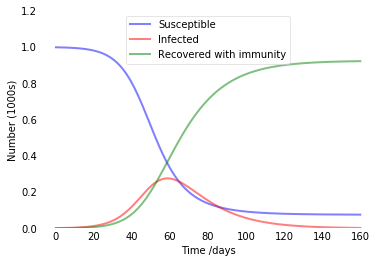

In [38]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

Take a look at https://github.com/Lewuathe/COVID19-SIR

Also take a look at https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

https://github.com/closedloop-ai/cv19index

https://github.com/CodeForPhilly/chime

https://github.com/coronafighter/coronaSEIR

Playing with SIR models from "Mathematical Epidemiology" page 23

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

In [39]:
N = 20_000_000 # Population
γ = 1/14.0 # Recovery rate, meaning that the mean infectious period is 1/γ
R0 = 2.5 # Basic reproduction number
β = R0 * γ / N # Transmission rate per capita
Δt = 0.1 # Time step for the solution method
f = 0.5/100 # fatality rate from number of cases

In [40]:
I = 1
S = N
Is = [I]
Ss = [S]
F0 = 0
Fs = [F0]
ts = np.arange(0,200,Δt)
for t in ts:
    if S < 0:
        S = 0
    if I < 0:
        I = 0
    S_new = S - β * S * I * Δt
    I_new = I + β * S * I * Δt - γ * I * Δt
    S = S_new
    I = I_new
    R = γ * I * Δt
    F0 += f * R
    Fs.append(F0)
    Ss.append(S)
    Is.append(I)
del Ss[-1] # kludge because for loop is not inclusive
del Is[-1]
del Fs[-1]

Text(0.5, 1.0, 'Simple S.I.R. Model\nγ=0.07142857142857142,$R_0$=2.5')

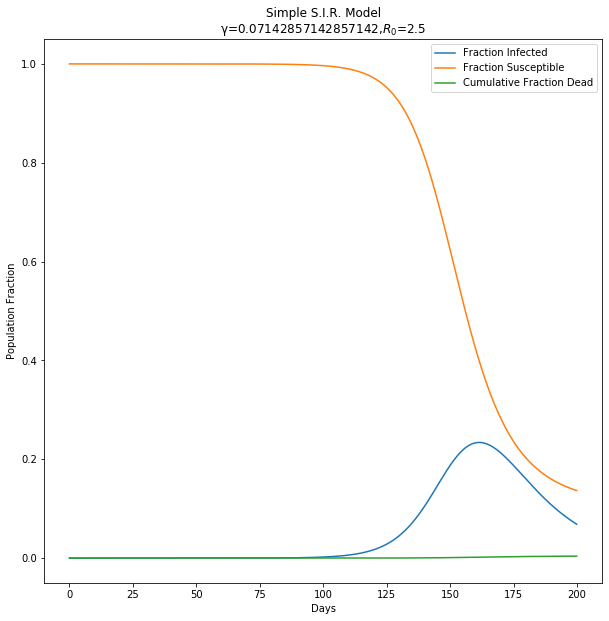

In [41]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(ts,np.array(Is)/N,ax=ax,label="Fraction Infected")
sns.lineplot(ts,np.array(Ss)/N,ax=ax,label="Fraction Susceptible")
sns.lineplot(ts,np.array(Fs)/N,ax=ax,label="Cumulative Fraction Dead")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Population Fraction")
ax.set_title(f"Simple S.I.R. Model\nγ={γ},$R_0$={R0}")

In [42]:
F0

79579.60274945182

## Let's set up a Bayesian Parameter Estimator

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

|Parameter|Interpretation|Value|References|
|---|---|---|---|
|$N$|County Population|2019 Estimate|DHS|
|$N_I$|Initial Infected Population|Fixed|Judgement|
|$\mathbf{R}_0$|Basic Reproduction Number|$\sim N(2.5,\sigma^2=1.5)$|Judgement|
|$\beta$|Transmission Rate Per Capita|$\sim N(1,\sigma^2=1)$|Judgement|
|$\gamma$|Recovery Rate|$\sim N(1,\sigma^2=1)$|Judgement|
|$f$|Fatality Fraction|$\sim N(1,\sigma^2=1)$|Judgement|

In [43]:
def SIR(fips,N,R0,γ,f,I=10,Δt=0.1,startDate=dt.datetime(year=2020,month=3,day=1),endDate=dt.datetime(year=2020,month=4,day=7)):
    # look up county population
    nDays = (endDate-startDate).days
    dates = [startDate + dt.timedelta(days=x) for x in range(nDays)]
    β = R0 * γ / N # Transmission rate per capita
    I = 1
    S = N
    Is = [I]
    Ss = [S]
    ts = np.arange(0,nDays,Δt)
    for t in ts:
        if S < 0:
            S = 0
        if I < 0:
            I = 0
        S_new = S - β * S * I * Δt
        I_new = I + β * S * I * Δt - γ * I * Δt
        S = S_new
        I = I_new
        Ss.append(S)
        Is.append(I)
    del Ss[-1] # kludge because for loop is not inclusive
    del Is[-1]
    df = pd.DataFrame({"date":dates,"I":Is[0::int(1/Δt)],"S":Ss[0::int(1/Δt)]})
    df = df.set_index("date")
    return df

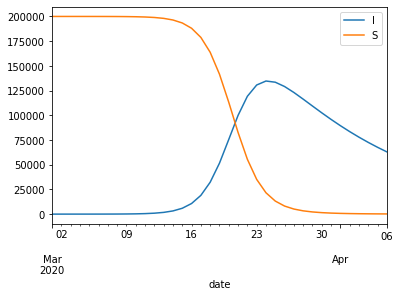

In [44]:
SIR(100.0,200000.0,10.0,1/14.,0.02).plot()

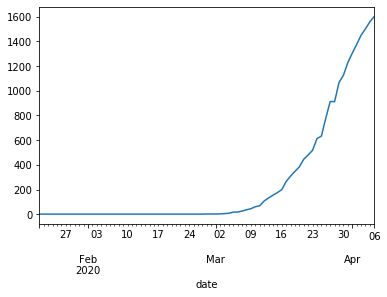

In [45]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==53061].set_index("date")["cases"].plot()

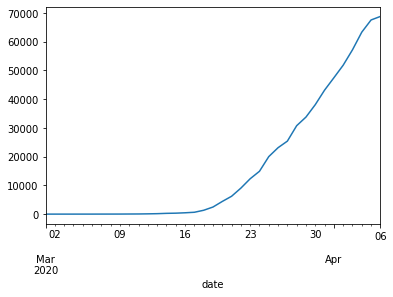

In [46]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==360470].set_index("date")["cases"].plot()

Note to self- cumulative cases seems to work

In [ ]:
gdf_countyTimeSeriesDiff.sort_values("cases")